## Import Library

In [35]:
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler

## Declare Session Builder

In [3]:
spark = SparkSession.builder.getOrCreate()

## Importing Dataset

In [5]:
df = spark.read.csv("dataset.csv", header=True, inferSchema = True) # kalau ada difolder lain datasetnya /data/dataset.csv, misal datasetnya ada di folder data


In [7]:
df.show(5) # ngecek isi datanya

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



## Query

In [8]:
df.createOrReplaceTempView("iris")

### Simple Query

In [9]:
spark.sql("SELECT * FROM iris WHERE species = 'setosa'").show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
|         5.4|        3.9|         1.7|        0.4| setosa|
|         4.6|        3.4|         1.4|        0.3| setosa|
|         5.0|        3.4|         1.5|        0.2| setosa|
|         4.4|        2.9|         1.4|        0.2| setosa|
|         4.9|        3.1|         1.5|        0.1| setosa|
|         5.4|        3.7|         1.5|        0.2| setosa|
|         4.8|        3.4|         1.6|        0.2| setosa|
|         4.8|        3.0|         1.4|        0.1| setosa|
|         4.3|        3.0|         1.1| 

In [10]:
df.filter(df.species == 'setosa').show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
|         5.4|        3.9|         1.7|        0.4| setosa|
|         4.6|        3.4|         1.4|        0.3| setosa|
|         5.0|        3.4|         1.5|        0.2| setosa|
|         4.4|        2.9|         1.4|        0.2| setosa|
|         4.9|        3.1|         1.5|        0.1| setosa|
|         5.4|        3.7|         1.5|        0.2| setosa|
|         4.8|        3.4|         1.6|        0.2| setosa|
|         4.8|        3.0|         1.4|        0.1| setosa|
|         4.3|        3.0|         1.1| 

## Advance Query

condition +  sort by average petal width (descending)

In [14]:
# Raw Query
spark.sql("""
SELECT 
    species,
    AVG(petal_width) AS avg_pw
FROM iris
WHERE petal_length > 1.5
GROUP BY species
ORDER BY avg_pw DESC
""").show()

+----------+------------------+
|   species|            avg_pw|
+----------+------------------+
| virginica|             2.026|
|versicolor|1.3259999999999998|
|    setosa|0.3076923076923077|
+----------+------------------+



In [15]:
# Query Builder
df.filter(df.petal_length > 1.5)\
    .groupBy("species")\
    .avg("petal_width")\
    .withColumnRenamed("avg(petal_width)", "avg_pw")\
    .orderBy("avg_pw", ascending=False)\
    .show()

+----------+------------------+
|   species|            avg_pw|
+----------+------------------+
| virginica|             2.026|
|versicolor|1.3259999999999998|
|    setosa|0.3076923076923077|
+----------+------------------+



## Visualization

In [18]:
# Pie Chart

pie_query = spark.sql("""
SELECT
    species,
    COUNT(*) AS count
FROM iris
GROUP BY species
""")

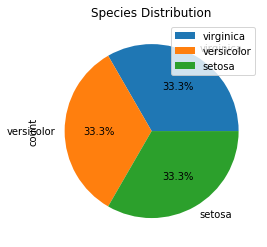

In [21]:
pie_pd = pie_query.toPandas()

pie_pd.set_index('species').plot.pie(y='count', legend=True, autopct="%1.1f%%")
plt.title("Species Distribution")
plt.show()

In [25]:
# bar Chart

bar_query = spark.sql("""
SELECT
    species,
    AVG(petal_width) AS avg_pw
FROM iris
GROUP BY species
""")

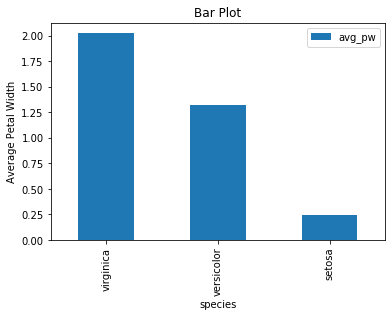

In [27]:
bar_pd = bar_query.toPandas()

bar_pd.plot.bar(x='species', y='avg_pw', legend=True)
plt.title("Bar Plot")
plt.xlabel("species")
plt.ylabel("Average Petal Width")
plt.show()

In [29]:
# Line Chart (Sepal Length in each species)

line_query = df.select("species", "sepal_length")\
    .orderBy("sepal_length")

line_pd = line_query.toPandas()

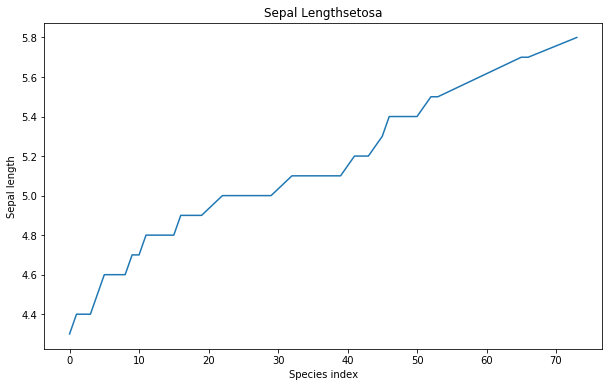

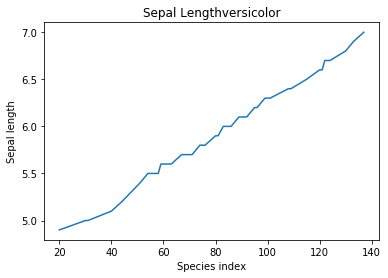

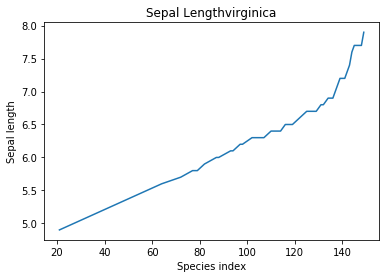

In [30]:
plt.figure(figsize=(10, 6))

for species in line_pd["species"].unique():
    species_df = line_pd[line_pd["species"] == species]
    plt.plot(species_df.index, species_df["sepal_length"], label = species)
    
    plt.title('Sepal Length' + species)
    plt.xlabel('Species index')
    plt.ylabel('Sepal length')
    plt.show()

## Machine Learning

## Preprocessing

In [ ]:
# Feature Selection
df_selected = df.select(["sepal_length"], ["petal_length"], ["species"])
df_selected.show()

In [ ]:
# drop na
df_selected = df_selected.na.drop()

In [ ]:
# encoding
# data: low, medium, high -> 0,1,2

df_encoded = df_selected.withColumn("species",\
                                    when(["species"] == "setosa", 0)\
                                    .when(["species"] == "versicolor", 1)\
                                    .when(["species"] == "verginica", 2))
df_encoded.show(5)

In [ ]:
# Normalisasi

# Gabungin feature

vec_df = VectorAssembler(inputCols=df_encoded.columns,\
                        outputCol="vector").transform(df_encoded)

In [ ]:
# standarisasi

scaled_df = StandardScaler(inputCol="vector", output="scaled").fit(vector_df).transform(vec_df)

scaled_df.show()